In [26]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression,LinearRegression,SGDRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score,classification_report, confusion_matrix, mean_absolute_error, mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR,LinearSVR,NuSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, GRU, LSTM, RepeatVector, TimeDistributed,Conv1D,MaxPooling1D,ReLU,UpSampling1D,Input,LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from keras.layers.core import Dense
from keras.layers.merge import concatenate
from tensorflow.keras.layers import Average
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
import pywt
from scipy.fft import fft,ifft
from sklearn.preprocessing import OneHotEncoder

In [27]:
data = pd.read_csv('train_FD001.txt', sep = ' ', header = None)
data.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
           dtype='int64')

In [28]:
data_act = data[[f for f in range(0, 26)]]
data_act.columns = ["ID", "Cycle", "OpSet1", "OpSet2", "OpSet3", "SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
len(np.unique(data_act['OpSet2']))

13

In [29]:
max_cycles_df = data_act.groupby(["ID"], sort=False)["Cycle"].max().reset_index().rename(columns={"Cycle" : "MaxCycleID"})
max_cycles_df.head()

,ID,MaxCycleID
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [30]:
FD001_df = pd.merge(data_act, max_cycles_df, how="inner", on="ID")
FD001_df["RUL"] = FD001_df["MaxCycleID"] - FD001_df["Cycle"]
FD001_df

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200,1


In [33]:
df_FD001 = FD001_df.copy().drop(columns=["ID", "Cycle", "OpSet1","OpSet2","OpSet3", "MaxCycleID", "RUL"], axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
# print(df_FD001)
scaled_df_FD001 = pd.DataFrame(scaler.fit_transform(df_FD001.values))
scaled_df_FD001 = FD001_df[["ID", "Cycle", "RUL", "OpSet1","OpSet2","OpSet3"]].join(scaled_df_FD001)
scaled_df_FD001.columns = ["ID", "Cycle","RUL","OpSet1","OpSet2", "OpSet3","SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
print(scaled_df_FD001['OpSet2'].value_counts().idxmax())
print(scaled_df_FD001['OpSet1'].value_counts().idxmax())

-0.0003
0.0


In [32]:
enc_id = OneHotEncoder()
enc_opset1 = OneHotEncoder()
enc_opset2 = OneHotEncoder()
id_enc = enc_id.fit_transform(scaled_df_FD001['ID'].values.reshape(-1,1)).toarray()
print(id_enc.shape)
opset1_enc = enc_opset1.fit_transform(scaled_df_FD001['OpSet1'].values.reshape(-1,1)).toarray()
print(opset1_enc.shape)
opset2_enc = enc_opset2.fit_transform(scaled_df_FD001['OpSet2'].values.reshape(-1,1)).toarray()
print(opset2_enc.shape)
print(type(id_enc))
print(type(opset1_enc))
print(type(opset2_enc))

(20631, 100)
(20631, 158)
(20631, 13)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
scaled_clean_df_FD001 = scaled_df_FD001.drop(columns=["SensorMeasure1", "SensorMeasure5", "SensorMeasure6", "SensorMeasure10",
                                         "SensorMeasure16", "SensorMeasure18", "SensorMeasure19"])
scaled_clean_df_FD001.columns

Index(['ID', 'Cycle', 'RUL', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure2',
       'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7', 'SensorMeasure8',
       'SensorMeasure9', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure17', 'SensorMeasure20', 'SensorMeasure21'],
      dtype='object')

In [9]:
num_col = ['SensorMeasure2',
       'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7', 'SensorMeasure8',
       'SensorMeasure9', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure17', 'SensorMeasure20', 'SensorMeasure21']

In [10]:
X_num_tr = scaled_clean_df_FD001[num_col].values
print(X_num_tr.shape)
print(type(X_num_tr))
X_tr = np.concatenate([X_num_tr,id_enc,opset1_enc,opset2_enc], axis = 1)
print(X_tr.shape)
y_tr = scaled_clean_df_FD001['RUL'].values
print(y_tr.shape)

(20631, 14)
<class 'numpy.ndarray'>
(20631, 285)
(20631,)


Text(0, 0.5, 'cumulative explained variance')

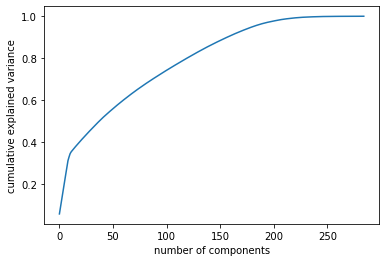

In [11]:
pca = PCA()
pca.fit(X_tr)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [12]:
pca = PCA(n_components=200)
X_tr_pc = pca.fit_transform(X_tr)

In [13]:
test_data_FD001 = pd.read_csv('test_FD001.txt', sep = ' ', header = None)
test_data_FD001 = test_data_FD001[[f for f in range(0, 26)]]
test_data_FD001.columns = ["ID", "Cycle", "OpSet1", "OpSet2", "OpSet3", "SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
test_data_FD001

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [14]:
max_cycles_df_test = test_data_FD001.groupby(["ID"], sort=False)["Cycle"].max().reset_index().rename(columns={"Cycle" : "MaxCycleID"})
max_cycles_df_test

,ID,MaxCycleID
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98
...,...,...
95,96,97
96,97,134
97,98,121
98,99,97


In [15]:
y_test_rul_FD001 = pd.read_csv('RUL_FD001.txt', header = None)
y_test_rul_FD001.columns = ['Eng_rul']
y_test_rul_FD001['ID'] = max_cycles_df_test['ID']
y_test_rul_FD001

,Eng_rul,ID
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [16]:
max_cycles_df_test['MaxCycleIDAct'] = y_test_rul_FD001['Eng_rul']+ max_cycles_df_test['MaxCycleID']
max_cycles_df_test

,ID,MaxCycleID,MaxCycleIDAct
0,1,31,143
1,2,49,147
2,3,126,195
3,4,106,188
4,5,98,189
...,...,...,...
95,96,97,234
96,97,134,216
97,98,121,180
98,99,97,214


In [17]:
test_df_FD001 = pd.merge(test_data_FD001, max_cycles_df_test, how="inner", on="ID")
test_df_FD001

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,MaxCycleIDAct
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,31,143
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,31,143
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,31,143
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,31,143
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,31,143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,198,218
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,198,218
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,198,218
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,198,218


In [18]:
test_df_FD001["RUL"] = test_df_FD001["MaxCycleIDAct"] - test_df_FD001["Cycle"]
test_df_FD001

,ID,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21,MaxCycleID,MaxCycleIDAct,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,31,143,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,31,143,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,31,143,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,31,143,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,31,143,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8.4715,0.03,394,2388,100.0,38.65,23.1974,198,218,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8.4512,0.03,395,2388,100.0,38.57,23.2771,198,218,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8.4569,0.03,395,2388,100.0,38.62,23.2051,198,218,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8.4711,0.03,395,2388,100.0,38.66,23.2699,198,218,21


In [19]:
te_df_FD001 = test_df_FD001.copy().drop(columns=["ID", "Cycle", "OpSet1", "OpSet2","OpSet3", "MaxCycleID", "MaxCycleIDAct","RUL"], axis=1)
# print(te_df_FD001)
scaled_te_df_FD001 = pd.DataFrame(scaler.transform(te_df_FD001.values))
scaled_te_df_FD001 = test_df_FD001[["ID", "Cycle", "RUL","OpSet1","OpSet2","OpSet3"]].join(scaled_te_df_FD001)
scaled_te_df_FD001.columns = ["ID", "Cycle","RUL", "OpSet1", "OpSet2", "OpSet3","SensorMeasure1", "SensorMeasure2", "SensorMeasure3", "SensorMeasure4",
                "SensorMeasure5", "SensorMeasure6", "SensorMeasure7", "SensorMeasure8", "SensorMeasure9", "SensorMeasure10", "SensorMeasure11",
                "SensorMeasure12", "SensorMeasure13", "SensorMeasure14", "SensorMeasure15", "SensorMeasure16",
                "SensorMeasure17", "SensorMeasure18", "SensorMeasure19", "SensorMeasure20", "SensorMeasure21"]
scaled_te_df_FD001

,ID,Cycle,RUL,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,142,0.0023,0.0003,100.0,0.0,0.545181,0.310661,0.269413,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,141,-0.0027,-0.0003,100.0,0.0,0.150602,0.379551,0.222316,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,140,0.0003,0.0001,100.0,0.0,0.376506,0.346632,0.322248,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348
3,1,4,139,0.0042,0.0000,100.0,0.0,0.370482,0.285154,0.408001,...,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110
4,1,5,138,0.0014,0.0000,100.0,0.0,0.391566,0.352082,0.332039,...,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,24,0.0049,0.0000,100.0,0.0,0.611446,0.619359,0.566172,...,0.426439,0.176471,0.584890,0.564063,0.0,0.500000,0.0,0.0,0.395349,0.418669
13092,100,195,23,-0.0011,-0.0001,100.0,0.0,0.605422,0.537388,0.671843,...,0.503198,0.308824,0.572350,0.485956,0.0,0.583333,0.0,0.0,0.333333,0.528721
13093,100,196,22,-0.0006,-0.0003,100.0,0.0,0.671687,0.482014,0.414754,...,0.530917,0.235294,0.605326,0.507888,0.0,0.583333,0.0,0.0,0.372093,0.429301
13094,100,197,21,-0.0038,0.0001,100.0,0.0,0.617470,0.522128,0.626435,...,0.562900,0.294118,0.622046,0.562524,0.0,0.583333,0.0,0.0,0.403101,0.518779


In [20]:
unknown_opset1 = [-0.0082, -0.0079, -0.0077, -0.0071, 0.0075, 0.0078]
unknown_opset2 = [0.0007]
for i in range(13096):
    if scaled_te_df_FD001['OpSet1'].iloc[i] in unknown_opset1:
        scaled_te_df_FD001['OpSet1'].iloc[i] = 0.0000
    if scaled_te_df_FD001['OpSet2'].iloc[i] in unknown_opset2:
        scaled_te_df_FD001['OpSet2'].iloc[i] = -0.0003

/Users/shivam.bhardwaj/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
id_enc_te = enc_id.transform(scaled_te_df_FD001['ID'].values.reshape(-1,1)).toarray()
opset1_enc_te = enc_opset1.transform(scaled_te_df_FD001['OpSet1'].values.reshape(-1,1)).toarray()
opset2_enc_te = enc_opset2.transform(scaled_te_df_FD001['OpSet2'].values.reshape(-1,1)).toarray()


In [22]:
X_te_num = scaled_te_df_FD001[num_col].values
X_te = np.concatenate([X_te_num, id_enc_te, opset1_enc_te, opset2_enc_te], axis = 1)
X_te_pc = pca.transform(X_te)
y_te = scaled_te_df_FD001['RUL'].values

In [23]:
def get_window(in_ar,out_ar,lb):
    in_seq = []
    out_seq = []
    for i in range(in_ar.shape[0]):
        if (i+lb) <= in_ar.shape[0]:
            seq = in_ar[i:i+lb,:]
            lab_rul = out_ar[(i+lb)-1]
            in_seq.append(seq)
            out_seq.append(lab_rul)
    in_seq = np.array(in_seq)
    out_seq = np.array(out_seq)
    return in_seq, out_seq

In [24]:
x_tr,y_tr = get_window(X_tr_pc,y_tr,128)
x_te,y_te = get_window(X_te_pc,y_te,128)
print(x_tr.shape,y_tr.shape)

(20504, 128, 200) (20504,)


In [25]:
def rul_model(batch_size = None,in_feature = x_tr.shape[2], out_f = 1, len_ts = x_tr.shape[1]):
    inp = layers.Input(batch_shape= (batch_size, len_ts, x_tr.shape[2]), name="Input")
    l1 = layers.Bidirectional(LSTM(units = int(x_tr.shape[2]/2),return_sequences = True), name = 'Bi-LSTM-1')(inp)
    l2 = layers.Bidirectional(LSTM(units = int(x_tr.shape[2]/4),return_sequences = False), name = 'Bi-LSTM-2')(l1)
    l3 = layers.Dense(units = 3, activation = 'relu', name = 'latent_space_rep')(l2)
    l4 = layers.RepeatVector(len_ts, name = 'RpVec')(l3)
    l5 = layers.Bidirectional(LSTM(units = int(x_tr.shape[2]/4),return_sequences = True), name = 'Bi-LSTM-3')(l4)
    l6 = layers.Bidirectional(LSTM(units = int(x_tr.shape[2]/2),return_sequences = True), name = 'Bi-LSTM-4')(l5)
    l7 = layers.TimeDistributed(Dense(units = x_tr.shape[2], activation = 'linear'), name = 'rec-layer')(l6)
    l8 = layers.Dense(units = 50, activation = 'relu', name = 'FC-1')(l3)
    out = layers.Dense(units = 1, activation = 'linear', name = 'rul-out')(l8)
    M = models.Model(inputs = inp, outputs =  [out,l7])
    M.compile(loss='mean_squared_error', optimizer='adam')
    return M
 
Model = rul_model()
Model.summary()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 128, 200)]   0                                            
__________________________________________________________________________________________________
Bi-LSTM-1 (Bidirectional)       (None, 128, 200)     240800      Input[0][0]                      
__________________________________________________________________________________________________
Bi-LSTM-2 (Bidirectional)       (None, 100)          100400      Bi-LSTM-1[0][0]                  
__________________________________________________________________________________________________
latent_space_rep (Dense)        (None, 3)            303         Bi-LSTM-2[0][0]                  
______________________________________________________________________________________________

In [ ]:
Model.fit(x_tr, [y_tr,x_tr], epochs=600, batch_size=4096, verbose=1, validation_split=0.25)

Epoch 1/600
